## Car Class


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [1]:
class Car(object):
    """
    Creates car and initializes location/orientation to 0, 0, 0.
    """
    def __init__(self, x=0.0, y=0.0, orientation=0.0, length=20.0):
        self.x = x
        self.y = y
        self.orientation = orientation
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    """
    Sets car coordinate.
    """
    def set(self, x, y, orientation): 
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    """
    Sets the noise parameters.
    """
    def set_noise(self, steering_noise, distance_noise):
        # Makes it possible to change the noise parameters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    """
    Sets the systematical steering drift parameter
    """
    def set_steering_drift(self, drift):
        self.steering_drift = drift

    """
    steering = front wheel steering angle, limited by max_steering_angle
    distance = total distance driven, most be non-negative
    """
    def move(self, steering, speed, delta_t=1.0, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if speed < 0.0:
            speed = 0.0

        # Apply noise
        actual_steering = random.gauss(steering, self.steering_noise)
        actual_distance = random.gauss(speed*delta_t, self.distance_noise) 

        # Apply steering drift
        actual_steering += self.steering_drift

        # Execute motion
        turn_angle = np.tan(actual_steering) * actual_distance / self.length

        if abs(turn_angle) < tolerance:
            # Approximate by straight line motion
            self.x += actual_distance * np.cos(self.orientation)
            self.y += actual_distance * np.sin(self.orientation)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
        else:
            # Approximate bicycle model for motion
            radius = actual_distance / turn_angle
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn_angle) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)  

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

## Implement P Controller
The Proportional term determines how hard the car will turn towards its desired trajectory.

Implement the P controller below

$steer(t) = - K_p * e_p(t)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, and $e_p$ is the cross-track error (error in y position)

Note: You shouldn't change any parameters other than kp when running the proportional controller

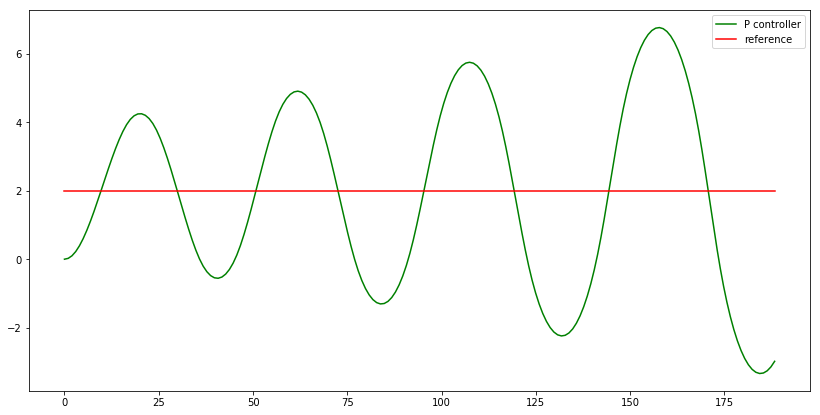

In [195]:
car = Car(x=0, y=0, orientation=0)

"""
Performs n actuations using proprotional control

Returns the list of actual x positions, actual y positions, and the desired y positions
Because we are not performing longitudinal control, there are no desired x positions

Parameters
----------
car : Car object 
    see car class defined above
kp : float
    proportional constant 
initial_step : float
    Initial desired y position of the car
step_size : float
    Amount to change desired y position
num_step : int
    The number of desired y positions
n : int
    Number of actuations to perform
speed : float
    speed of the car IN WHAT DIMENSION?

Returns
-------
x_trajectory : List of floats
    The actual x positions of the car over time
y_trajectory : List of floats
    The actual y positions of the car over time
desired_y_trajectory: List of floats
    The desired y positions of the car over time

"""
def run_pcontroller(car, kp, initial_step=2.0, step_size=2.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []

    desired_y = initial_step       # DESIRED Y VALUE
    #prev_ep = car.y - initial_step # PREVIOUS CROSS TRACK ERROR
    for i in range(n):
        if (i % (n // num_steps) == 0 and i > 0):
            desired_y += step_size
        # Append to trajectory lists
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        
        # Update values
        cur_ep = car.y - desired_y_trajectory[-1]
        #car.set(car.x, car.y, -kp * cur_ep)
        car.move(-kp * cur_ep, speed)
        #prev_ep = car.y - desired_y
    
    return x_trajectory, y_trajectory, desired_y_trajectory

# Anything above 1 will overshoot
kp = 0.4

x_trajectory, y_trajectory, desired_y_trajectory = run_pcontroller(car, kp=kp)

plt.figure(figsize=(14,7))
plt.plot(x_trajectory, y_trajectory, 'g', label='P controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.legend()
plt.show()


## Implement PD Controller
The Derivative term determines how much the car will resist changes in its position.

In this exercise, because $\Delta t$ is always one, we will can just calculate a simple difference to implement the PD controller.

Implement the PD controller below

$steer(t) = - K_p * e_p(t) - K_d * e_d(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, $e_p$ is the cross-track error (error in y position), $K_d$ is the derivative constant, and $e_d$ is the derivative error. 

Note: You shouldn't be changing any parameters other than kp and kd when running the controller. You are, however, free to change how you define the derivative error. You do not have to only use two points. You are free to experiment and try averaging the slopes of more than two points.

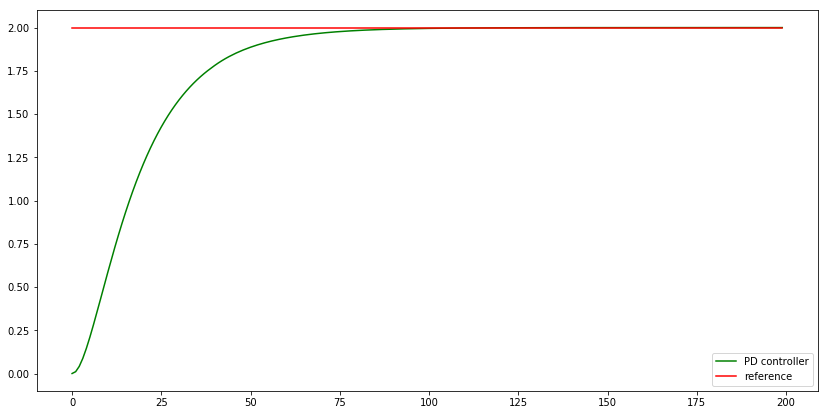

In [205]:
car = Car(x=0, y=0, orientation=0)

"""
Performs n actuations using proprotional derivative control assuming car moves at constant speed

Returns the list of actual x positions, actual y positions, and the desired y positions
Because we are not performing longitudinal control, there are no desired x positions

Parameters
----------
car : Car object 
    see car class defined above
kp : float
    proportional constant 
kd: float
    derivative constant
initial_step : float
    Initial desired y position of the car
step_size : float
    Amount to change desired y position
num_step : int
    The number of different desired y positions
n : int
    Number of actuations to perform
speed : float
    speed of the car

Returns
-------
x_trajectory : List of floats
    The actual x positions of the car over time
y_trajectory : List of floats
    The actual y positions of the car over time
desired_y_trajectory: List of floats
    The desired y positions of the car over time
"""
def run_pdcontroller(car, kp, kd, initial_step=2.0, step_size=2.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y # previous proportional error
    for i in range(n):
        if (i%(n//num_steps) == 0 and i > 0):
            desired_y += step_size
        
        # Append to trajectory lists
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        
        # Update values
        cur_ep = car.y - desired_y_trajectory[-1]
        steer = (-kp * cur_ep) + (-kd * (cur_ep - prev_ep))  # Difference for derivative
        car.move(steer, speed)
        prev_ep = cur_ep
        
    return x_trajectory, y_trajectory, desired_y_trajectory

kp = 0.2
kd = 4.2

x_trajectory, y_trajectory, desired_y_trajectory = run_pdcontroller(car, kp=kp, kd=kd)

plt.figure(figsize=(14,7))
plt.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.legend()
plt.show()

## Implement PID Controller
The Integral term offsets any bias that is causing the car to accumulate a offset, such as wind that is consistently pushing the car to the left. 

In this exercise, you can model the integral as a basic summation as shown below, or you can try more accurate techniques like the trapezoidal rule, etc. It's up to you to experiment.

Implement the PID controller below

$steer(t) = - K_p * e_p(t) - K_d * e_d(t) - K_i * e_i(t)$

$e_d(t) = e_{p}(t) - e_{p}(t-1)$

$e_i(t) = \displaystyle\sum_{t}e_p(t)$

where $steer$ is the steering angle of the car in radians, $K_p$ is the proportional constant, $e_p$ is the cross-track error (error in y position), $K_d$ is the derivative constant, $e_d$ is the derivative error, $K_i$ is the integral constant, and $e_i$ is the integral error. 

Note: You shouldn't be changing any parameters other than kp, kd, and ki when running the controller

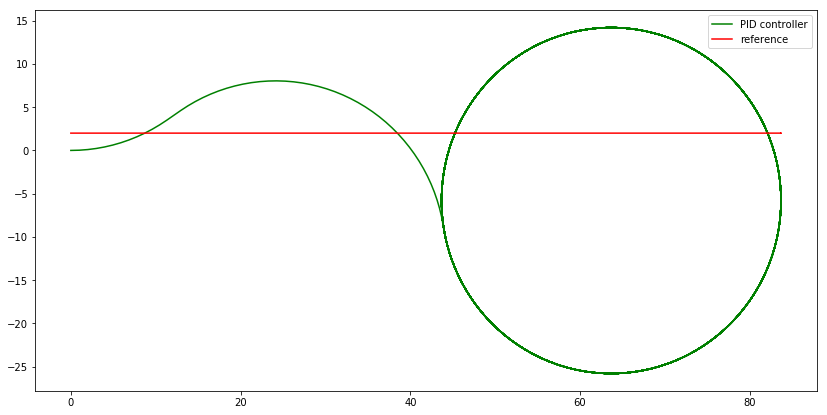

In [214]:
car = Car(x=0, y=0, orientation=0)

#TODO: When you've implemented the entire PID controller below, try adding some noise and drift
car.set_noise(0.0,0.0)
car.set_steering_drift(0.0)

"""
Performs n actuations using proprotional derivative integral control assuming car moves at constant speed

Returns the list of actual x positions, actual y positions, and the desired y positions
Because we are not performing longitudinal control, there are no desired x positions

Parameters
----------
car : Car object 
    see car class defined above
kp : float
    proportional constant 
kd: float
    derivative constant
ki: float
    integral constant
initial_step : float
    Initial desired y position of the car
step_size : float
    Amount to change desired y position
num_step : int
    The number of different desired y positions
n : int
    Number of actuations to perform
speed : float
    speed of the car

Returns
-------
x_trajectory : List of floats
    The actual x positions of the car over time
y_trajectory : List of floats
    The actual y positions of the car over time
desired_y_trajectory: List of floats
    The desired y positions of the car over time
"""
def run_pidcontroller(car, kp, kd, ki, initial_step=2.0, step_size=2.0, num_steps=1, n=2000, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    desired_y_trajectory = []
    
    desired_y = initial_step
    prev_ep = car.y - desired_y # previous proportional error
    sum_ep = 0
    ei = 0 # initial integral error
    for i in range(n):
        if (i % (n // num_steps) == 0 and i > 0):
            desired_y += step_size
        # Append to trajectory lists
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        desired_y_trajectory.append(desired_y)
        
        # Update values
        cur_ep = car.y - desired_y_trajectory[-1]
        sum_ep += cur_ep
        steer = (-kp * cur_ep) + (-kd * (cur_ep - prev_ep)) + (-ki * sum_ep)
        car.move(steer, speed)
        prev_ep = cur_ep
        
    return x_trajectory, y_trajectory, desired_y_trajectory

#TODO: Play with these values
kp = 0.3
kd = 0.0
ki = 0.1

x_trajectory, y_trajectory, desired_y_trajectory = run_pidcontroller(car, kp=kp, kd=kd, ki=ki)

plt.figure(figsize=(14,7))
plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.legend()
plt.show()

### Let's Twiddle: PID Auto-Tuning Algorithm

Twiddle is an algorithm that automatically tunes the parameters of your pid controller up and down similar to how a human would twiddle the parameters to bring the average error down. 

The general idea is to loop through all of your parameters, trying small changes in them, until changing them by small amounts no longer causes a decrease in your average error. 

First you try increasing by some change, like 0.2. See if that decreases the error. If it does, increase the change by a small amount, like 10% and continue. If it doesn't, try decreasing the parameter by 0.2. If this decreases your error, then you once again increase the change by a small amount, like 10% and continue. If neither increasing nor decreasing the parameter causes a decrease in the average error, then make your change smaller by a small amount, like 10%, and try twiddling the parameter again in the next iteration.

If that is confusing, try reading the psuedo code below:

```
# Define your initial parameters kp, kd, ki to all zeroes in some array
p = [0.0, 0.0, 0.0]
# Define your initial changes in parameters that you wish to try to see if these changes decrease your error
dp = [0.2, 0.2, 0.2]
# run one iteration of the pid controller to get the average error
best_err = run()

while (sum of differences in parameters > some tolerance):
   print(best_err) # for debugging; make sure your error is converging and not timing out
   for i in range(len(p)):
       p[i] += dp[i]
       err = run()
       if (err < best_err):
           best_err = err
           dp[i] *= 1.1
       else:
           p[i] -= 2*dp[i]
           err = run()
           if (err < best_err):
               best_err = err
               dp[i] *= 1.1
           else:
               p[i] += dp[i]
               dp[i] *= 0.9
```

Now code it up. 

Once you have twiddle working, feel free to try playing with the ```run()``` function to design a cost function that suits your needs. Instead of basing the cost off of the average cross-track error, maybe try designing a cost function that tries to achieve a specific rise time, overshoot, etc, or some combination of all the characteristics you want your controller to have. It's all up to you.

Final twiddle error = 2.0
('params: ', [0.0, 0.0, 0.0])


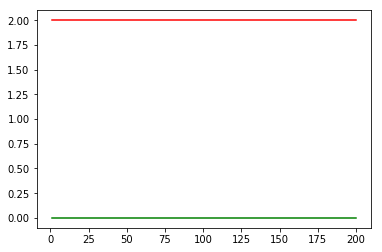

In [5]:
"""
Resets the car back to the initial position and drift.
You'll want to call this every time after you run your pid controller.
"""
def make_car():   
    # TODO: change drift_angle, steering_noise, and distance_noise to your assigned values
    drift_angle = 10.0
    steering_noise = 0.10
    distance_noise = 0.10
    car = Car(x=0, y=0, orientation=0)
    car.set_steering_drift(drift_angle / 180 * np.pi)
    car.set_noise(steering_noise, distance_noise)
    return car

desired_y_trajectory = []
# NOTE: We use params instead of kp, kd, ki
def run(car, params, initial_step=2.0, step_size=2.0, num_steps=1, n=200, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = car.y
    int_cte = 0
    desired_y = initial_step
    global desired_y_trajectory
    desired_y_trajectory = []
    for i in range(n):
        if (i%(n//num_steps)==0 and i > 0):
          desired_y += step_size
        desired_y_trajectory.append(desired_y)
        cte = car.y - desired_y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        car.move(steer, speed)
        x_trajectory.append(car.x)
        y_trajectory.append(car.y)
        err += abs(cte)
    return x_trajectory, y_trajectory, err / n

# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.001):
    # Don't forget to call `make_car` before every call of `run`!
    car = make_car()
    p = [0.0, 0.0, 0.0]
    dp = [0.2, 0.2, 0.2]
    x_trajectory, y_trajectory, best_err = run(car, p)
    # TODO: twiddle loop here

    return p, best_err


params, err = twiddle()

print("Final twiddle error = {}".format(err))
car = make_car()
x_trajectory, y_trajectory, err = run(car, params)
print("params: ", params)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, desired_y_trajectory, 'r', label='reference')
plt.show()